# Analysis of bis and S&P500 correlation

In [1]:
from prepare_financial_data import PrepareFinancialData
from prepare_bis_data import PrepareBisData
from utils import plot_speach

from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
from sentiment_analysis import SentimentAnalysis
from sklearn.metrics import mutual_info_score

import shap
import xgboost as xgb
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import phik
import seaborn as sns
import datetime as dt




warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(11.7,8.27)})
path_to_files='./bisCrawler/speeches'

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/kamil/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
2023-01-19 16:58:08.670637: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-19 16:58:08.670652: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


At first few words about scrapping the internet. 
The crawler proposed in the task definition was poor quality. I must fix it and just a little bit.
So the data from crawler are in 1-day chunks in ./bisCrawler/speeches. So at the start, we need to load this data.


In [2]:
bis_data=PrepareBisData(path_to_files)

Now we will get and process data from S&P500. The time range will be similar to data from BIS granulation will be 1 day.


In [3]:
financial_data_object=PrepareFinancialData('1d','^GSPC',bis_data)

Let's plot the index and the rates of return.

<AxesSubplot: xlabel='Date', ylabel='Open'>

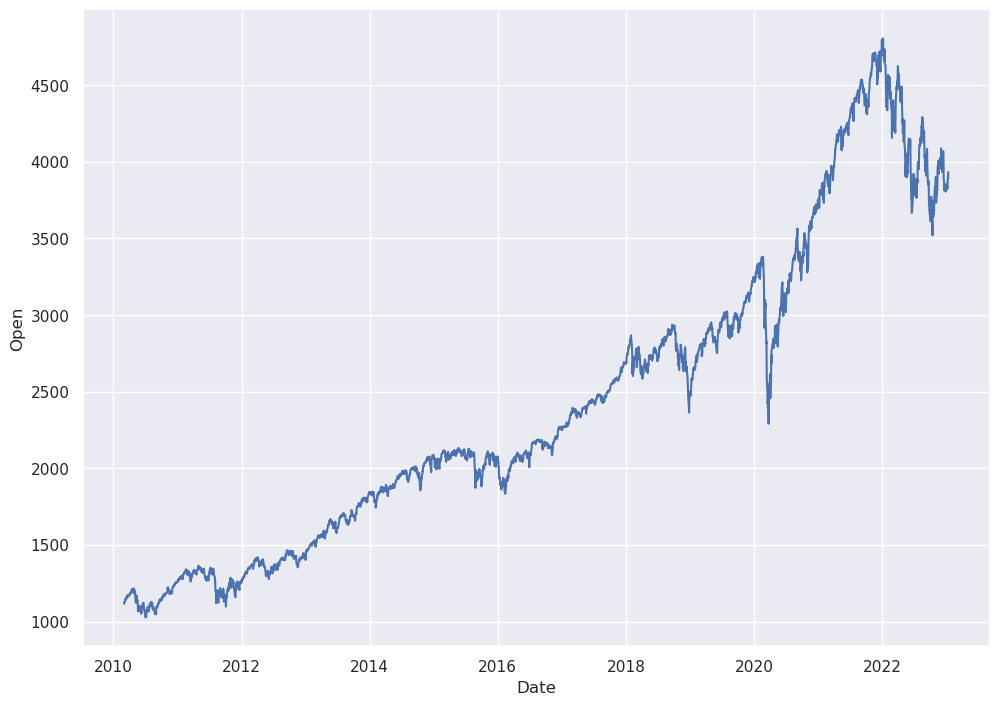

In [4]:
 sns.lineplot(data=financial_data_object.historical_data, x='Date', y='Open')

<AxesSubplot: xlabel='Date', ylabel='rates_of_return'>

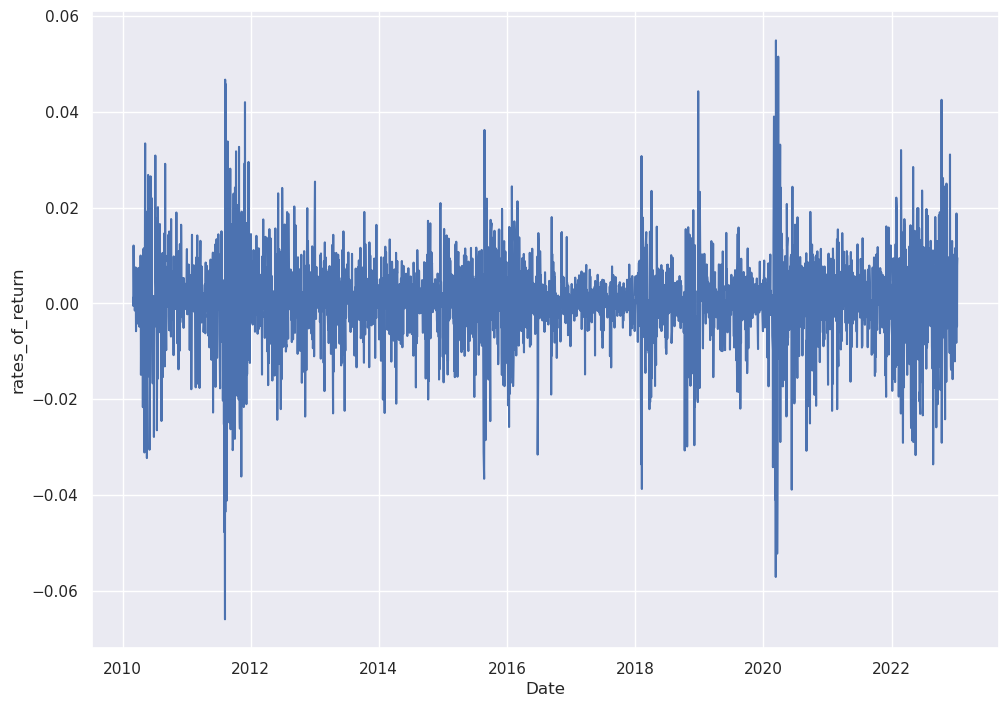

In [5]:
sns.lineplot(data=financial_data_object.rates_of_return, x='Date', y='rates_of_return')

Let's try to put speaches on this graph and get some intuition.

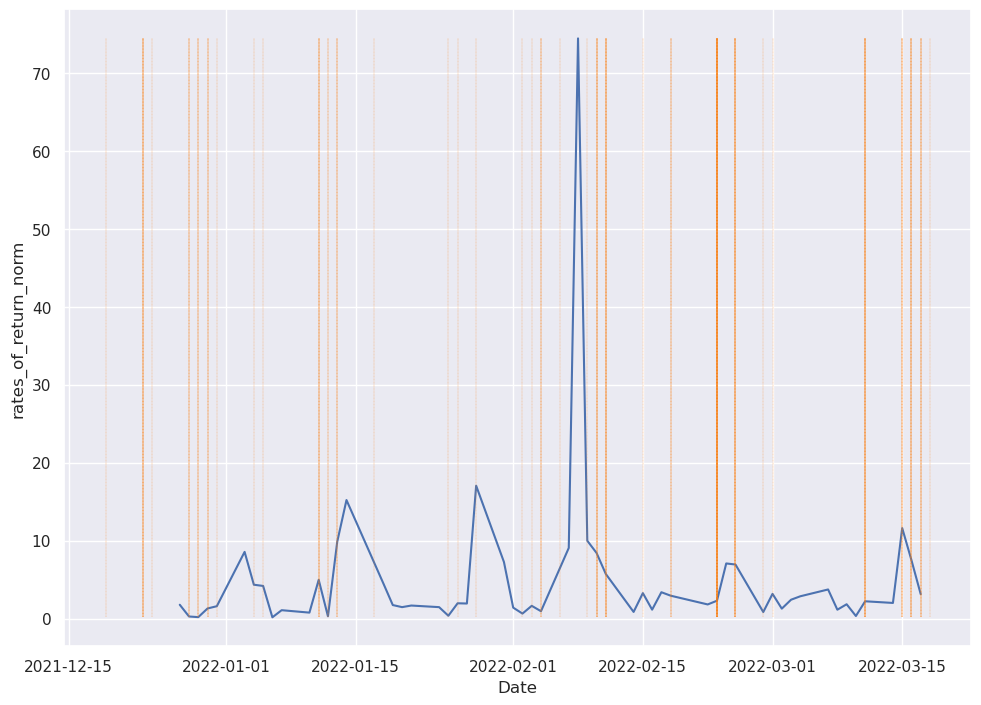

In [6]:
index_start=-700
index_end=-600
rates='rates_of_return_norm'
sns.set(rc={'figure.figsize':(11.7,8.27)})
bis_data_vis=PrepareBisData(path_to_files,index_start,index_end)
plot_speach(index_start, index_end, rates, bis_data_vis)

The stock market from its nature is very unstable. A lot of factors have influenced prices, from markets' long-term trends to black swans like the Russian invasion of Ukraine. So to messure the correlation between speeches and market reaction we need somehow minimalize the influence of other factors.
Here are steps of my analysis:
  1. I created rates of return from daily open and closing prices. (Close/Open)-1
  2. Calculate the moving average on rates of return.
  3. Calculate the difference between the moving average and rates of return to get rid of the trend from data
  4. Calculate the ratio of moving average and rates of return to normalized data.
  5. I calculated absolute values from points 3 and 4.
  6. Created binary variables from points 3 and 4 using quantiles. If the value was greater than some quantile (default 0.9) I coded that as 1 (some jump n data) and 0 otherwise.

I created also additional variables to code speeches. When on the given day there was a speech I code that as 1 and 0 otherwise. Also created two additional variables speech_was_yeasterday and speech_will_be_tommorow. Due to the knowledge that the marker always is representing the expectations of the investors and discounts rather future than the present.

In [7]:
#here I'm calculating correlation of binary variables.
corelation_matrix=financial_data_object.binary_returns.phik_matrix()

interval columns not set, guessing: ['binary_diff', 'binary_norm', 'binary', 'is_speech', 'speech_was_yeasterday', 'speech_will_be_tommorow']


In [8]:
corelation_matrix

,binary_diff,binary_norm,binary,is_speech,speech_was_yeasterday,speech_will_be_tommorow
binary_diff,1.000000,0.244335,0.598056,0.000000,0.018064,0.000000
binary_norm,0.244335,1.000000,0.217946,0.031279,0.000000,0.021402
binary,0.598056,0.217946,1.000000,0.000000,0.011109,0.000000
is_speech,0.000000,0.031279,0.000000,1.000000,0.500375,0.500375
speech_was_yeasterday,0.018064,0.000000,0.011109,0.500375,1.000000,0.304114
speech_will_be_tommorow,0.000000,0.021402,0.000000,0.500375,0.304114,1.000000


As we can see we have some weak correlation with normalized rates_of_return also this correlation is visible in the speech_will_be_tommorow label. This is representing the expectations of investors. The main problem here is to get rid of all additional factors. But this is not a new thing that the stock market is unpredictable. Also, we need to remember that we have an effective market hypothesis and all information about speech is probably already discounted. Also rarely every these speeches are surprising.

Additionally we can check if we can find some correlation of speaker and market reaction. 

In [56]:
index_start=-700
index_end=-1
bis_data=PrepareBisData(path_to_files,index_start,index_end)
financial_data_object=PrepareFinancialData('1d','^GSPC',bis_data)
spekers=financial_data_object.create_one_hot_name()
correlation=spekers.phik_matrix(verbose=False)
correlation['binary_norm'].sort_values(ascending=False)[:15].to_frame()

,binary_norm
binary_norm,1.000000
binary_diff,0.246052
binary,0.220121
Fabio Panetta,0.176846
Patrick Njoroge,0.096112
Pablo Hernández de Cos,0.089084
Michelle W Bowman,0.084913
Nor Shamsiah Mohd Yunus,0.075405
Sharon Kozicki,0.074645
Per Jansson,0.074645


We can see that some executives have more influence on the market than others. What is interesting is that Mr. Jerome Powell is not present here. Maybe he is too predictable.

### Summary.
In general presents of speech have a low influence on the stock market but we can't say that there is no correlation at all. Also, we shouldn't be expected that all speakers will be having the same impact on stock markets

# Sentiment analysis

In this sentiment analysis, we will use Vader module from nltk. We will proceed with analysis as follows:
 1. For each speech we will try to get a pdf.
 2. From pdf we will extract text.
 3. On extracted text we will proceed with sentiment analysis with SentimentIntensityAnalyzer from nltk.vader. No additional preprocessing of text is needed
 4. Due to a lot of errors, we will handle all exceptions and skip them.
 5. If the compound is positive we mark sentiment as positive if nonpositive as negative.


In [2]:
#creating data frame with speeches.
bis_data_for_sentiment_analysis=PrepareBisData(path_to_files).create_bis_data()

In [3]:
#fetching pdfs and sentiment analysis
check_sentiment=SentimentAnalysis()
Links=bis_data_for_sentiment_analysis.pdf.values
sentiment=Parallel(n_jobs=25)(delayed(check_sentiment)(link) for link in Links)

In [4]:
#adding sentiment to the data frame
bis_data_for_sentiment_analysis['sentiment_binary']=[sent[2] for sent in sentiment]
bis_data_for_sentiment_analysis['compound']=[sent[1] for sent in sentiment]
bis_data_for_sentiment_analysis['sentiment']=[sent[0] for sent in sentiment]

bis_data_for_sentiment_analysis.dropna(subset='sentiment',inplace=True)

In [5]:
#bis_data_for_sentiment_analysis.to_csv('./resources/sentiment.csv')

Let's count how often the given sentiment occures:

In [55]:
bis_data_for_sentiment_analysis[['sentiment']].value_counts().to_frame()

,0
sentiment,
pos,5633
neg,494


Let's see how often given speakers are giving negative and positive speeches:

In [41]:
sentiment_name_pos=bis_data_for_sentiment_analysis[['Name','sentiment']].where(bis_data_for_sentiment_analysis['sentiment']=='pos').groupby(['sentiment'])
sentiment_name_neg=bis_data_for_sentiment_analysis[['Name','sentiment']].where(bis_data_for_sentiment_analysis['sentiment']=='neg').groupby(['sentiment'])

In [42]:
sentiment_name_pos.value_counts().to_frame().sort_values(by=[0],ascending=False)

0
sentiment Name                                          
pos       Benjamin E Diokno                          113
          Andreas Dombret                            100
          François Villeroy de Galhau                 96
          Benoît Cœuré                                96
          Mario Draghi                                88
...                                                  ...
          Thomas C Baxter, Jr                          1
          Thomas C Baxter, Jr and Sarah J Dahlgren     1
          Bojan Markovic                               1
          Beverly Hirtle                               1
          Sabine Lautenschläger and Andreas Dombret    1

[572 rows x 1 columns]

In [51]:
sentiment_name_neg.value_counts().to_frame().sort_values(by=[0],ascending=False)

0
sentiment Name                
neg       Claudia Buch      20
          Jens Weidmann     18
          Isabel Schnabel   15
          Peter Praet       12
          Patrick Honohan   11
...                         ..
          Senad Softić       1
          Seppo Honkapohja   1
          Serey Chea         1
          Stefan Gerlach     1
          Øystein Olsen      1

[190 rows x 1 columns]

In [44]:
bis_data_for_sentiment_analysis[['Name']].value_counts().to_frame()

,0
Name,
Benjamin E Diokno,116
Andreas Dombret,110
Benoît Cœuré,106
François Villeroy de Galhau,99
Mario Draghi,91
...,...
Rasheed Mohammed Al-Maraj,1
Hitoshi Suzuki,1
Rekha Chifuwe Mhango,1


What is interesting is also correlation between sentiment and rates of return

In [52]:
#binary encoding of sentimentc
financial_data_object=PrepareFinancialData('1d','^GSPC',PrepareBisData(path_to_files))

In [53]:
#correlation of sentiment and binary returns (details on binary returns are above and in prepare_financial_data.py)
binary_returns=financial_data_object.binary_returns
binary_returns.merge(bis_data_for_sentiment_analysis['sentiment_binary'], on=['Date', 'Date']).phik_matrix(verbose=False)[['sentiment_binary']]

,sentiment_binary
binary_diff,0.000000
binary_norm,0.014212
binary,0.000000
speech_was_yeasterday,0.000000
speech_will_be_tommorow,0.000000
sentiment_binary,1.000000


In [54]:
#correlation of sentiment and continuous rates of return.
rates_of_return=financial_data_object.rates_of_return
rates_of_return.merge(bis_data_for_sentiment_analysis[['compound']], on=['Date', 'Date']).phik_matrix(verbose=False)[['compound']]


,compound
rates_of_return,0.070557
absolute_rates_of_return,0.075810
moving_average,0.036334
rates_of_return_diff,0.006336
rates_of_return_norm,0.000000
compound,1.000000


### Summary
In, In general, most speeches are positive about 92%. And this is nothing surprising since the central bankers don't want any panics in the markets so they trying to wrap their conclusions in nice words. We can also that the negative or positive tone is probably also the style of speaking and it sticks to the person. We can see some correlation of sentiment and rates of return it's week but still we can't ignore that factor.

## Bonus task

For the given period we will go to forecast the closing price given the sentiment of the speech and the opening price of the S&P500. If no speech was given on this day we assume sentiment is 0.

In [81]:
#corona period
index_start=4368
index_end=5448
financial_data_object=PrepareFinancialData('1d','^GSPC',PrepareBisData(path_to_files,index_start,index_end))

Here we are preparing proper data set.

In [330]:
bonus_task=pd.DataFrame()
bonus_task['Open']=financial_data_object.historical_data['Open']
bonus_task['Close']=financial_data_object.historical_data['Close']
bonus_task['Index']=financial_data_object.historical_data.index
grouped_compound=bis_data_for_sentiment_analysis[index_start:index_end][['compound']].groupby('Date').sum()
bonus_task=bonus_task.merge(grouped_compound['compound'], on=['Date', 'Date'],how='left')
bonus_task.fillna(0,inplace=True)
bonus_task.reset_index(drop=True,inplace=True)
bonus_task.set_index(['Index'],inplace=True)

In [331]:
y=bonus_task[['Close']]
X=bonus_task[['Open','compound']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Training and evaluating the model:

In [333]:
model=xgb.XGBRegressor(n_estimators=80, max_depth=4, eta=0.1)
model.fit(X_train, y_train)
y_pred_test= model.predict(X_test)
y_pred_train= model.predict(X_train)
y_train['Close_pred']=y_pred_train
y_test['Close_pred']=y_pred_test
bonus_task['Close_pred_test']=y_test['Close_pred']
bonus_task['Close_pred_train']=y_train['Close_pred']

In [334]:
train_mse=mean_squared_error(y_train['Close'],y_train['Close_pred'])
test_mse=mean_squared_error(y_test['Close'],y_test['Close_pred'])
train_mpe=mean_absolute_percentage_error(y_train['Close'],y_train['Close_pred'])
test_mpe=mean_absolute_percentage_error(y_test['Close'],y_test['Close_pred'])
print(f'MSE test {round(test,2)} MPE {round(test_mpe,2)}')
print(f'MSE train {round(train,2)} MPE {round(train_mpe,2)}')

MSE test 2088.54 MPE 0.01
MSE train 465.41 MPE 0.0


The model is slithly overfitted but acceptable.

Calculating shap values:

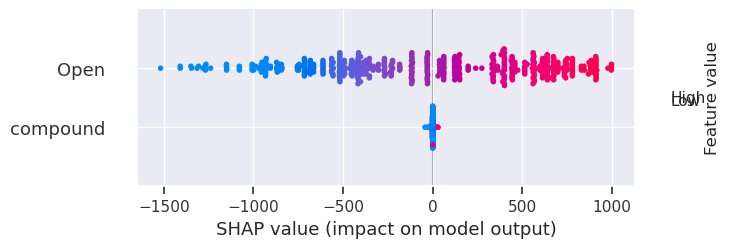

In [327]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

From shap values we can see that influence on model from speech is marginal.

Visualization of predictions on test and train set.

<AxesSubplot: xlabel='Index', ylabel='Close_pred_test'>

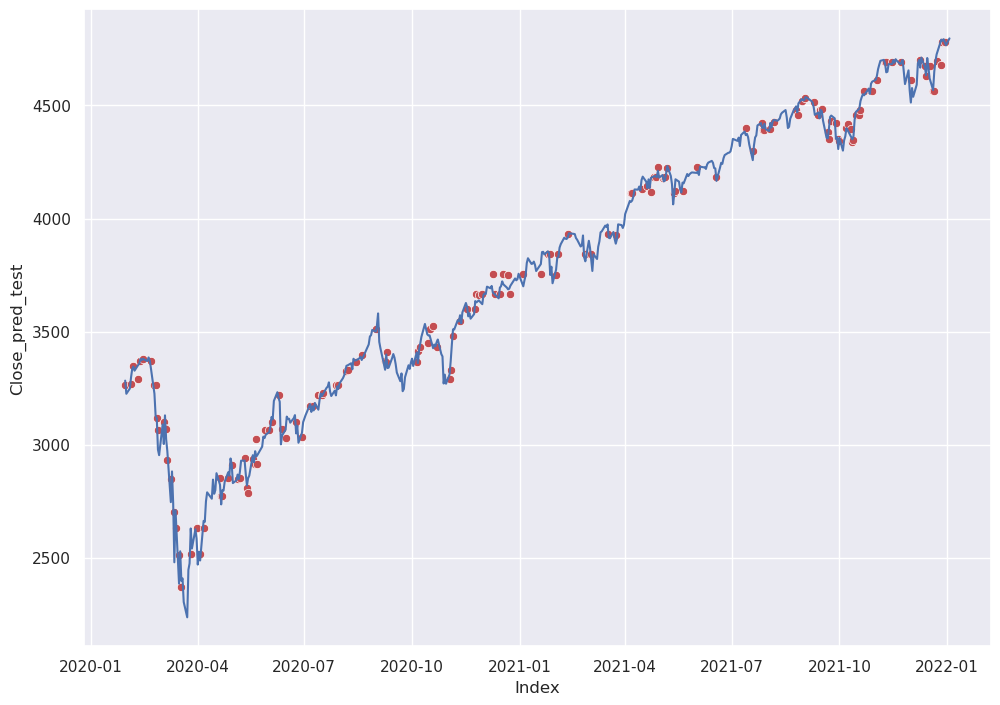

In [328]:
sns.scatterplot(data=bonus_task, x='Index', y='Close_pred_test',color='r')
sns.lineplot(data=bonus_task, x='Index', y='Close')

<AxesSubplot: xlabel='Index', ylabel='Close_pred_train'>

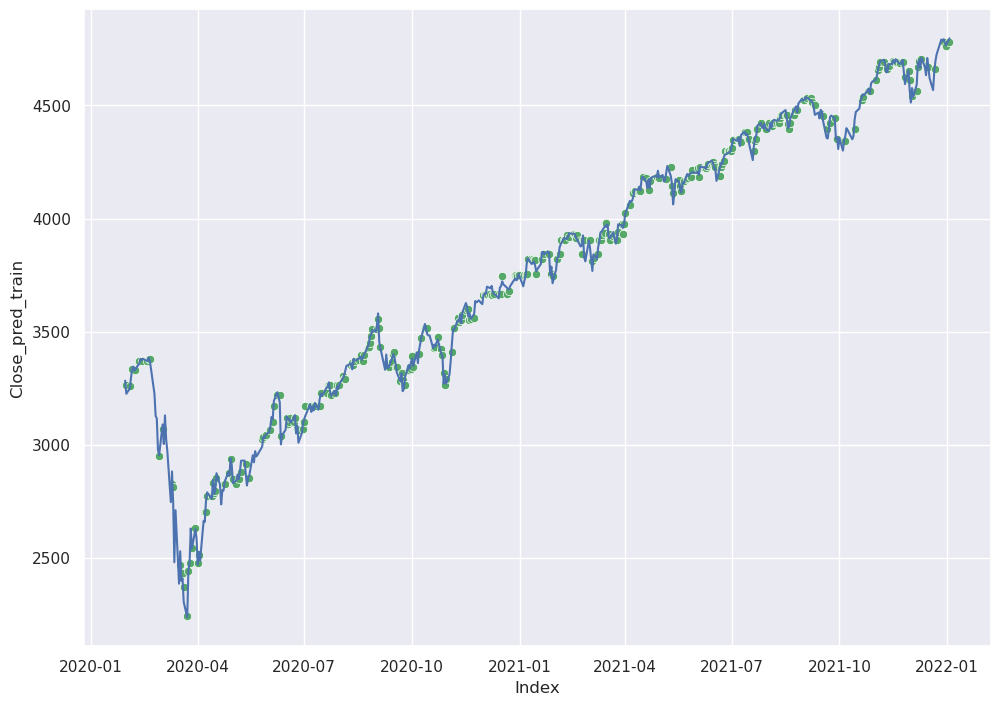

In [329]:
sns.scatterplot(data=bonus_task, x='Index', y='Close_pred_train',color='g')
sns.lineplot(data=bonus_task, x='Index', y='Close')

### Summary
As we can see our model is predicting quite well. We used xgboost so it's can't extrapolate the trend so it's some additional information in data that allows us to predict the closing prices. Also as we can see the sentiment of speech has a very low influence of speech.